# Question Answering using RAG

Una vez vistas las distintas técnicas de recuperación de información y como evaluar su efectividad en el notebook `rag.ipynb` en este notebook vamos a introducir un modelo de lenguaje para responder las preguntas.

In [2]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


In [3]:
import torch

device_setup= "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Usando: ", device_setup)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Usando:  mps


Vamos a implementar un sistema de question answering que utilice los distintos retrievers del notebook `rag.ipynb`. Para simplificar la reutilización del código, en la carpeta `./lib/rag-lib.py` hay un fichero python que implementa todos los retrievers de dicho notebook. La clase `RetrieverFactory` posee el método estático `RetrieversFactory.get_retrievers()` que devuelve un array con las instancias de todos los retrievers vistos.

In [4]:
from libs.rag_lib import RetrieversFactory, LLMModel, format_dataset, evaluate_qa_system, plot_evaluation_results

retrievers = RetrieversFactory.get_retrievers()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Q&A System

In [6]:
class QuestionAnswering:

    def __init__(self, generator, rag):
        self.generator = generator
        self.rag = rag

    def answer(self, query, lang="spanish", do_sample=True, show_prompt=False, temperature=0.1):
        relevant_documents = self.rag.search_documents(query, lang=lang)
        answer = self.generator.answer(query, relevant_documents, show_prompt=show_prompt, use_context=True, do_sample=do_sample, temperature=temperature)
        return answer

### Pruebas manuales

Vamos a usar el conjunto de datos vistos en notebooks anteriores y darles formato para poder evaluar un sistema de pregunta respuesta.

In [22]:
from datasets import load_dataset, Dataset

ragbench = load_dataset("rungalileo/ragbench", "hotpotqa", split=["test"])

# Le da formato al dataset: [documents, queries, gold-std]
dataset = format_dataset(ragbench[0])

A continuación, vamos a usar la clase `LLModel` para crear el componente para generar las respuestas usando el contexto. Usando esa clase y un retriever vamos a construir un objeto `QueryAnswering` y comprobar si para una query del dataset responde correctamente de manera qualitativa

In [23]:
from libs.rag_lib import LLMModel

generator = LLMModel()
retriever = retrievers[0]
print("Usando retriever: ",type(retriever))
retriever.build_index(dataset['documents']) # construimos el índice para los documentos

RuntimeError: MPS backend out of memory (MPS allocated: 18.04 GB, other allocations: 47.83 MB, max allowed: 18.13 GB). Tried to allocate 250.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Construcción del sistema Q&A
qa_model = QuestionAnswering(generator, retriever)

# Extraemos del dataset la query identificada como `5ae151985542990adbacf74d` y su respuesta
questions_dict = dataset['queries']
question = questions_dict['5ae151985542990adbacf74d']
expected_answer = dataset['responses']['5ae151985542990adbacf74d']

# Generamos una respuesta con el sistema
answer = qa_model.answer(question, lang="english", show_prompt=True)
# DONE: ¿Cómo podemos saber si se está teniendo en cuenta el contexto? usando show_prompt=True
# DONE: Probar a variar la temperatura y ver las respuestas que se obtienen

# Visualizamos
print("Question: ", question)
print("Answer obtained: ", answer)
print("Answer expected: ", expected_answer)

#### Tarea QAR1

Usando el código anterior, probar el sistema de question answering con la query y respuesta cuyo identificador es `5ab3d69255429969a97a81c9`

In [ ]:
# DONE: Extraemos del dataset la query identificada como `5ab3d69255429969a97a81c9` y su respuesta
questions_dict = dataset['queries']
question = questions_dict['5ab3d69255429969a97a81c9']
expected_answer = dataset['responses']['5ab3d69255429969a97a81c9']

# DONE: Generamos una respuesta con el sistema
answer = qa_model.answer(question, lang="english", show_prompt=True)
# DONE: Probar a variar la temperatura y ver las respuestas que se obtienen

# DONE: Visualizamos
print("Question: ", question)
print("Answer obtained: ", answer)
print("Answer expected: ", expected_answer)

#### Tarea QAR2

Usando el código anterior, probar el sistema de question answering con el dataset `rungalileo/ragbench`, en particular, el subconjunto `techqa` y la partición de test

In [ ]:
from datasets import load_dataset

# DONE: load "rungalileo/ragbench", subset "techqa", partition "test"
ragbench = load_dataset("rungalileo/ragbench", "techqa", split=["test"])
# DONE: use the function format_dataset to format the data
dataset = format_dataset(ragbench[0])

In [ ]:
# DONE: Extraemos del dataset la query identificada como `techqa_DEV_Q243` y su respuesta
questions_dict = dataset['queries']
question = questions_dict['techqa_DEV_Q243']
expected_answer = dataset['responses']['techqa_DEV_Q243']

# DONE: Generamos una respuesta con el sistema
answer = qa_model.answer(question, lang="english", show_prompt=True)

# DONE: Visualizamos
print("Question: ", question)
print("Answer obtained: ", answer)
print("Answer expected: ", expected_answer)

## Evaluando el sistema RAG vs el baseline

Como hemos podido ver en las tareas anteriores, comprar las salidas esperadas con las obtenidas no es trivial. En la siguiente celda vamos a ver un conjunto de métricas para comparar dichos pares.

In [7]:
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
import nltk
nltk.download('wordnet')

def evaluate_qa_system_adv(models, dataset):
    results_by_model = {}

    # Métricas y helpers
    vectorizer = TfidfVectorizer()
    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    for model_name, model in models:
        metrics = {
            "bleu": [],
            "rouge": {"rouge1": [], "rouge2": [], "rougeL": []},
            "meteor": [],
            "exact_match": [],
            "f1": [],
            "cosine_similarity": []
        }

        for entry in dataset:
            query = entry["question"]
            ground_truth = entry["answer"]

            # Respuesta del modelo
            prediction = model.answer(query=query)

            # BLEU
            smoothing_function = SmoothingFunction()
            bleu_score = sentence_bleu([ground_truth.split()], prediction.split(), smoothing_function=smoothing_function.method1)
            metrics["bleu"].append(bleu_score)

            # ROUGE
            rouge_scores = rouge_scorer_obj.score(ground_truth, prediction)
            for rouge_metric in ["rouge1", "rouge2", "rougeL"]:
                metrics["rouge"][rouge_metric].append(rouge_scores[rouge_metric].fmeasure)

            # METEOR
            meteor = meteor_score([ground_truth.split()], prediction.split())
            metrics["meteor"].append(meteor)

            # Exact Match
            exact_match = int(prediction.strip() == ground_truth.strip())
            metrics["exact_match"].append(exact_match)

            # F1 Score
            y_true = set(ground_truth.split())
            y_pred = set(prediction.split())
            common = y_true & y_pred
            precision = len(common) / len(y_pred) if y_pred else 0
            recall = len(common) / len(y_true) if y_true else 0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
            metrics["f1"].append(f1)

            # Cosine Similarity
            tfidf_matrix = vectorizer.fit_transform([ground_truth, prediction])
            cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            metrics["cosine_similarity"].append(cosine_sim)

        # Promediar resultados
        avg_metrics = {
            "bleu": np.mean(metrics["bleu"]),
            "rouge": {k: np.mean(v) for k, v in metrics["rouge"].items()},
            "meteor": np.mean(metrics["meteor"]),
            "exact_match": np.mean(metrics["exact_match"]),
            "f1": np.mean(metrics["f1"]),
            "cosine_similarity": np.mean(metrics["cosine_similarity"])
        }
        results_by_model[model_name] = avg_metrics

    return results_by_model

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Usando las funciones anteriores, vamos a evaluar una pequeña parte del dataset. Para ello, primero lo filtramos

In [8]:
ragbench= load_dataset("rungalileo/ragbench", "covidqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 5:
        break

### Evaluación de LLM con el contexto (gold-std) y sin contexto

Construimos un modelo LLM y lo evaluamos usando el contexto del propio dataset (el perfecto) y sin contexto. De esta manera vemos los resultados que se obtendrían sin introducir los posibles fallos de los retrievers

In [9]:
llm_model = LLMModel()
models = [
    ("TinyLlama-1-NC", llm_model, False),
    ("TinyLlama-2-C", llm_model, True)
]
# Esta fución de evaluación recupera del dataset el contexto relevante para una pregunta y, si está configurado, invoca al LLM proporcionándole dicho contexto
results_by_model = evaluate_qa_system(models, dataset)

### Evaluación de Q&A con un retriever

A continuación, vamos a ver que impacto llegan a tener los retrievers en la efectividad. Los resultados obtenidos deberían ser mejores que los conseguidos con `TinyLlama-1-NC` y cuanto más cercanos a `TinyLlama-1-C`.

Los distintos retrievers de los que disponemos son: `SparseRetriever()`, `SparseRetrieverNM()`, `DenseRetriever()`, `DenseRetriever( model='distiluse-base-multilingual-cased-v1')`, `HybridRetriever()`, `HybridRetriever(model='distiluse-base-multilingual-cased-v1')`

In [13]:
from libs.rag_lib import SparseRetriever, SparseRetrieverNM, DenseRetriever, DenseRetriever, HybridRetriever, HybridRetriever

# Cargamos todos los documentos del dataset para los retrievers
dataset_formattted = format_dataset(ragbench[0])
documents = dataset_formattted['documents']
# Construimos los retrievers
retriever = SparseRetriever()
retriever.build_index(documents)
# TODO: probar con los distintos retrievers
# Construimos un sistema de Q&A
models = [ ("Q&A-RAG-Sparse", QuestionAnswering(llm_model, retriever)) ]

# Esta función de evaluación nunca proporciona el contexto a los modelos
results_by_model_qa = evaluate_qa_system_adv(models, dataset)

Finalmente, solo queda visualizar los distintos resultados obtenidos

Resultados para  TinyLlama-1-NC
bleu :  0.061234699913165866
rouge :  {'rouge1': 0.28911565790386606, 'rouge2': 0.17244058872746684, 'rougeL': 0.27431085817427336}
meteor :  0.28564005691034533
exact_match :  0.0
f1 :  0.2757235326159005
cosine_similarity :  0.2540663847829872
Resultados para  TinyLlama-2-C
bleu :  0.152295952846437
rouge :  {'rouge1': 0.4078894172589525, 'rouge2': 0.26589746682625937, 'rougeL': 0.37442961599427316}
meteor :  0.380702952988037
exact_match :  0.0
f1 :  0.3674881477023923
cosine_similarity :  0.39806836358547576
Resultados para  Q&A-RAG-Sparse
bleu :  0.11768392609695917
rouge :  {'rouge1': 0.40780941116837033, 'rouge2': 0.23003565062388592, 'rougeL': 0.36409225310467175}
meteor :  0.34105956383224934
exact_match :  0.0
f1 :  0.3325036620344246
cosine_similarity :  0.3417919084592205


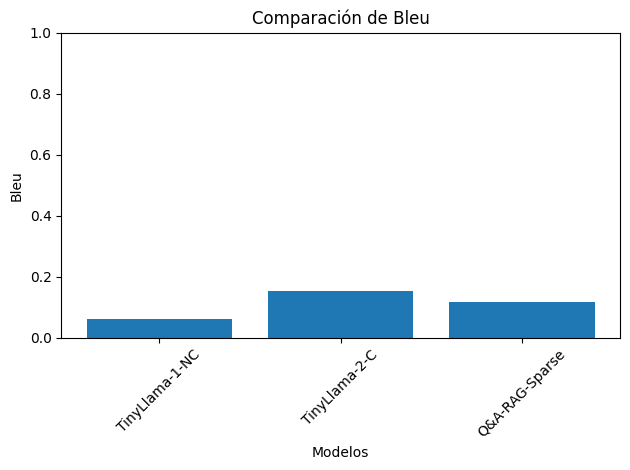

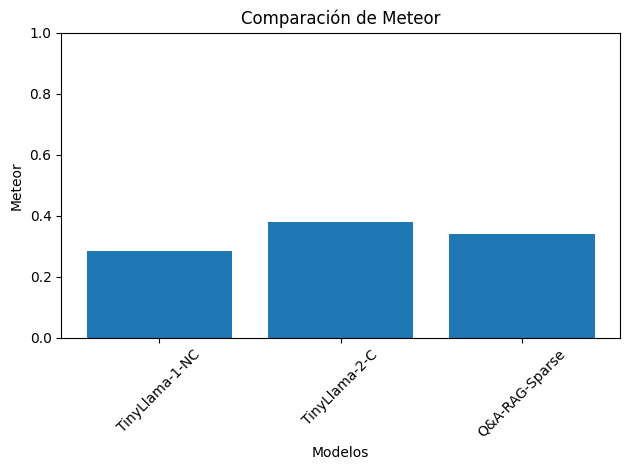

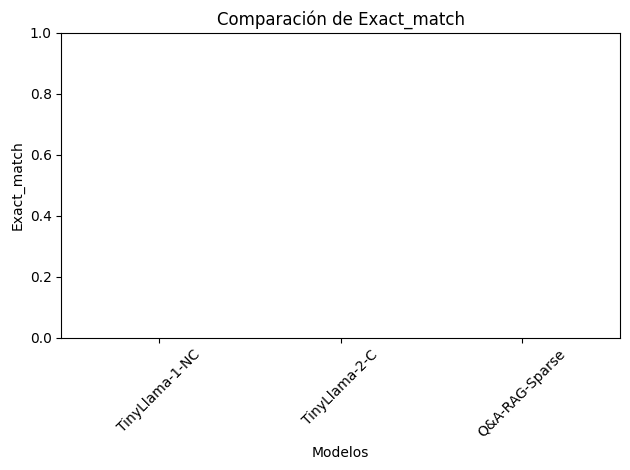

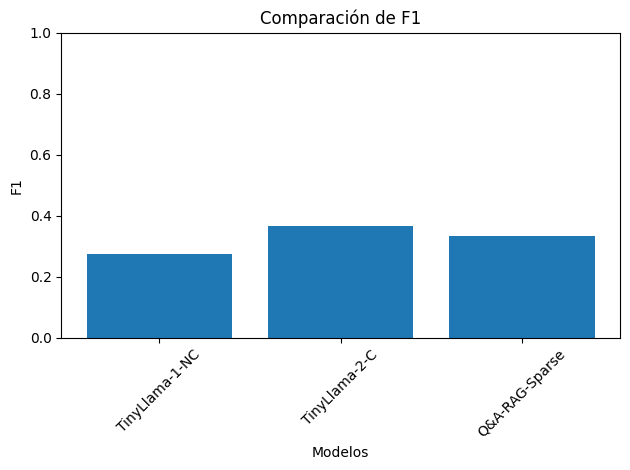

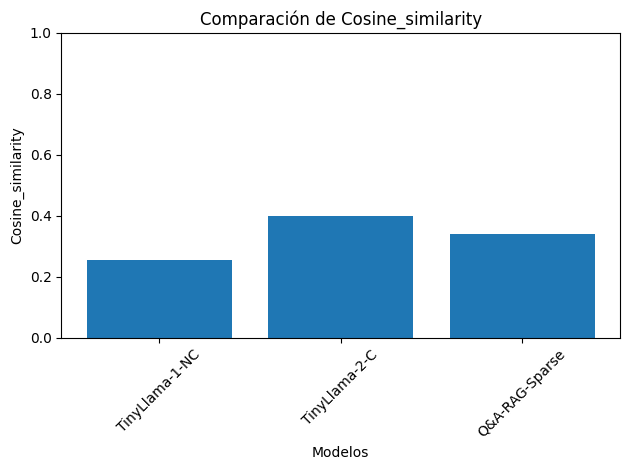

In [14]:
# Combinamos los resultados uniéndolos
results_by_model = results_by_model | results_by_model_qa

# Mostramos los resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Representamos los resultados en gráficas
plot_evaluation_results(results_by_model)

### Evaluando con rag-mini-wiki

#### Tarea QA3

Utilizando el código anterior y el dataset 'rag-datasets/rag-mini-wikipedia' realizar una evaluación

In [15]:
from datasets import load_dataset

# DONE: descargar el dataset y preparar en una variable `dataset` las preguntas, las respuestas y los documentos, limitarlo a 10 preguntas en principio
questions = load_dataset("rag-datasets/rag-mini-wikipedia", "question-answer", split=["test"])
passages = load_dataset("rag-datasets/rag-mini-wikipedia", "text-corpus", split=["passages"])

dataset = []
index = 0
for ds_row in questions[0]:
    dataset.append({"question" : ds_row["question"], "documents" : [], "answer" : ds_row["answer"] })
    index += 1
    if index == 10:
        break

# DONE: Preparar los documentos de contexto  para los retriever
documents = passages[0]["passage"]

In [17]:
# TODO: crear y evaluar un modelo LLM que no use contexto
ll_model = LLMModel()
models = [
    ("TinyLlama-1-NC", ll_model, False)
]
results_by_model = evaluate_qa_system(models, dataset)

In [18]:
# TODO: Crear una instancia de question answering usando el SparseRetriever

retriever =  SparseRetriever()
retriever.build_index(documents)
models = [ ("Q&A-RAG-Sparse", QuestionAnswering(ll_model, retriever)) ]


# TODO: Evaluar el modelo de question answering
results_by_qa = evaluate_qa_system_adv(models, dataset)

Resultados para  TinyLlama-1-NC
bleu :  0.0018199120881600083
rouge :  {'rouge1': 0.05196528176372761, 'rouge2': 0.009411764705882354, 'rougeL': 0.05196528176372761}
meteor :  0.03449453551912569
exact_match :  0.0
f1 :  0.01639344262295082
cosine_similarity :  0.08757281934472885
Resultados para  Q&A-RAG-Sparse
bleu :  0.05530988980499367
rouge :  {'rouge1': 0.1385130519220239, 'rouge2': 0.08859711170055998, 'rougeL': 0.1385130519220239}
meteor :  0.1376006291973903
exact_match :  0.0
f1 :  0.08465934065934066
cosine_similarity :  0.17837878887525205


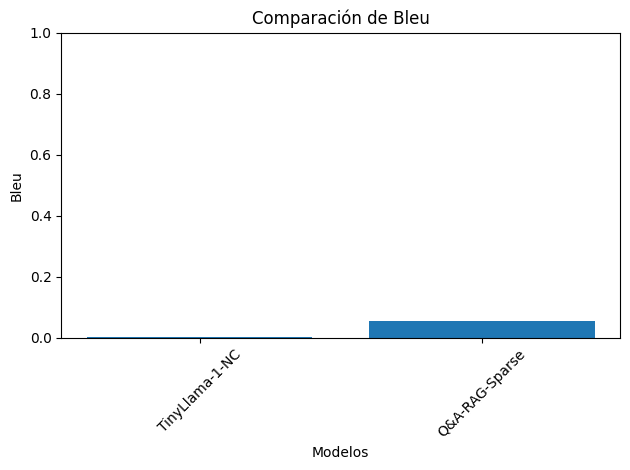

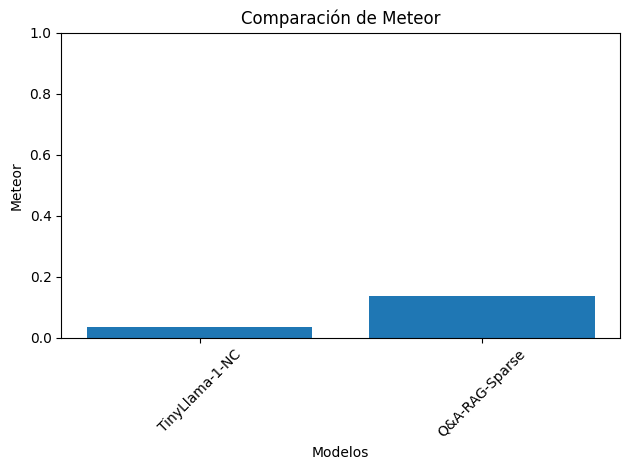

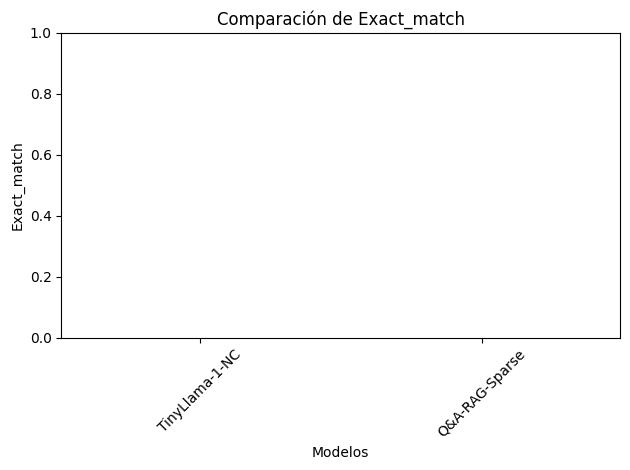

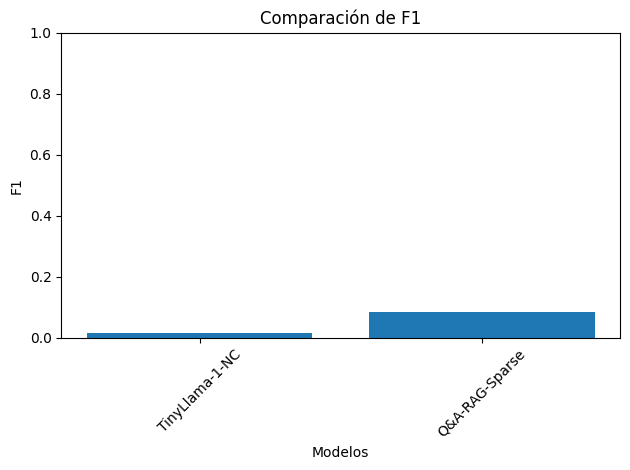

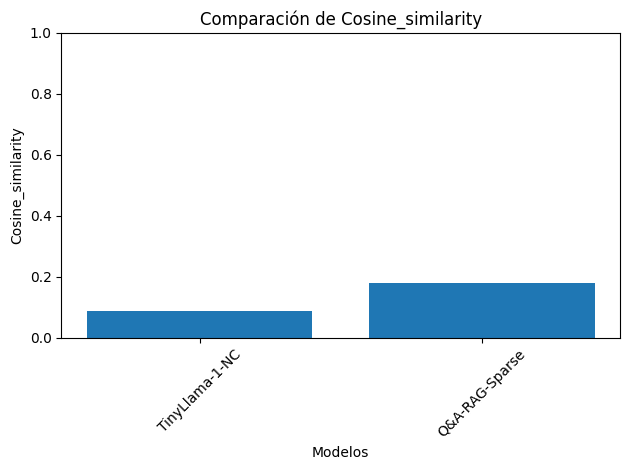

In [19]:
# TODO: combinar los resultados con los anteriores
results_by_model = results_by_model | results_by_qa # combine

# TODO: Mostrar resultados por pantalla e imprimir las gráficas
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)
